In [87]:
!pip install loguru

# Data Exploration

In [88]:
!mkdir -p /tmp
!curl https://raw.githubusercontent.com/urmzd/rabbit-classifier/main/resources/data.csv --output /tmp/data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9380  100  9380    0     0  89333      0 --:--:-- --:--:-- --:--:-- 89333


In [89]:
import pandas as pd
import requests
import os
import re
import pathlib
from loguru import logger

DATA_PATH="/tmp/data.csv"
IMAGE_PATH="/tmp/images"

def get_data():
  df = pd.read_csv(DATA_PATH, usecols=range(2))
  return df

def download_image(link: str) -> pathlib.Path:
  # view  : https://regex101.com/r/3bhDMM/1
  # delete: https://regex101.com/delete/N5sItwbrPF73ZllTnRDltxZ1
  file_name_regex = re.compile(r".*\/(.*(\.(jpeg|jpg|png))?)\??.*", flags=re.IGNORECASE)
  regex_matches = file_name_regex.match(link)

  if not regex_matches:
    raise Exception(f"Failed to match file_name for link {link}")

  if len(regex_matches.groups()) < 3:
    file_name = regex_matches.group(1) + ".png"
  else:
    file_name = regex_matches.group(1)

  content_path = pathlib.Path(IMAGE_PATH)
  content_path.mkdir(parents=True, exist_ok=True)

  file_path = content_path / file_name

  if file_path.exists():
    return file_path

  image_request_headers={
      'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
  }

  image = requests.get(link, headers=image_request_headers)

  with open(file_path, "wb") as handle:
    handle.write(image.content)

  return file_path

df = get_data()
df.head()

label                                               link
0  rabbit  https://upload.wikimedia.org/wikipedia/commons...
1  rabbit  https://upload.wikimedia.org/wikipedia/commons...
2  rabbit  https://www.massaudubon.org/var/ezdemo_site/st...
3  rabbit  https://www.welcomewildlife.com/wp-content/upl...
4  rabbit  https://i.natgeofe.com/k/58df97a7-5c47-44b8-97...

In [90]:
import cv2
from typing import NewType, Optional, Tuple, List
import numpy as np
from google.colab.patches import cv2_imshow

Image = NewType('Image', np.array)
Label = NewType('Label', str)
ImageLabelPair = Tuple[Image, Label]

def get_image(file_path: pathlib.Path, show=False) -> Image:
  image = cv2.imread(str(file_path))

  if show:
    cv2_imshow(image)
    
  return Image(image)

RawX = NewType('RawX', List[Image])
RawY = NewType('RawY', np.ndarray)

def get_x_y(raw_data: pd.DataFrame) -> Tuple[RawX, RawY]:
  y = df.iloc[:, 0].to_numpy()
  logger.info(y)
  y = y.reshape(-1, 1)

  x_links = df.iloc[:, 1].tolist()
  x_paths = [download_image(link) for link in x_links]
  x = [get_image(path) for path in x_paths]

  return RawX(x), RawY(y)

get_x_y(get_data())[1].shape

2022-03-15 00:57:27.943 | INFO     | __main__:get_x_y:23 - ['rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'hare' 'hare'
 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare'
 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare'
 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare'
 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare']


(85, 1)

2022-03-15 00:57:30.185 | INFO     | __main__:get_x_y:23 - ['rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit'
 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'rabbit' 'hare' 'hare'
 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare'
 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare'
 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare'
 'hare' 'hare' 'hare' 'hare' 'hare' 'hare' 'hare']
2022-03-15 00:57:32.230 | INFO     | __main__:get_x_y_preprocessors:7 - (85, 1)
2022-03-15 00:57:32.263 | INFO     | __main__:get_processed_x_y:29 - 0 (200, 200, 3) https://upload.wikimedia.org/wikipedia/commons/d/df/Eastern_Cottontail.JPG


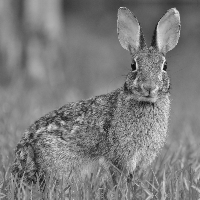

2022-03-15 00:57:32.304 | INFO     | __main__:get_processed_x_y:29 - 1 (200, 200, 3) https://upload.wikimedia.org/wikipedia/commons/4/4f/Wild_rabbit_us.jpg


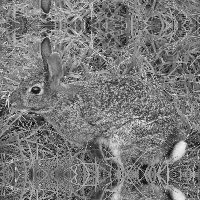

2022-03-15 00:57:32.352 | INFO     | __main__:get_processed_x_y:29 - 2 (200, 200, 3) https://www.massaudubon.org/var/ezdemo_site/storage/images/site_ma/learn/nature-wildlife/mammals/cottontail-rabbits/situations-solutions/176132-10-eng-US/situations-solutions.jpg


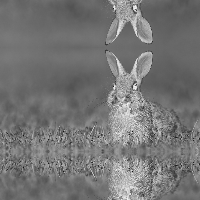

2022-03-15 00:57:32.413 | INFO     | __main__:get_processed_x_y:29 - 3 (200, 200, 3) https://www.welcomewildlife.com/wp-content/uploads/2019/01/Cottontail-%C2%A9-James-Chen-Shutterstock-scaled-e1640111841484.jpg


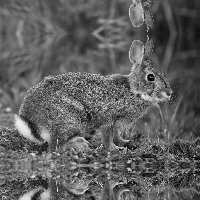

2022-03-15 00:57:32.483 | INFO     | __main__:get_processed_x_y:29 - 4 (200, 200, 3) https://i.natgeofe.com/k/58df97a7-5c47-44b8-97c1-cddecd7d4a4f/full-body-cottontail_4x3.jpg


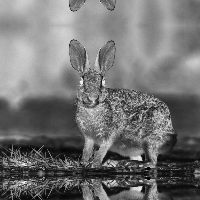

2022-03-15 00:57:32.523 | INFO     | __main__:get_processed_x_y:29 - 5 (200, 200, 3) https://upload.wikimedia.org/wikipedia/commons/0/0f/Sylvilagus_audubonii_2.jpg


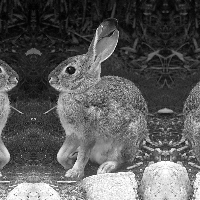

2022-03-15 00:57:32.563 | INFO     | __main__:get_processed_x_y:29 - 6 (200, 200, 3) https://northernnester.com/wp-content/uploads/2020/01/cottontail-rabbits.jpg


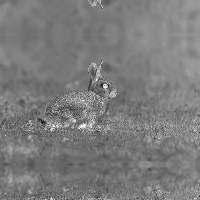

2022-03-15 00:57:32.615 | INFO     | __main__:get_processed_x_y:29 - 7 (200, 200, 3) https://www.reconnectwithnature.org/getmedia/04322096-c66a-49ad-8780-1d51ffeee519/Cottontail-rabbit-Shutterstock.jpg.aspx


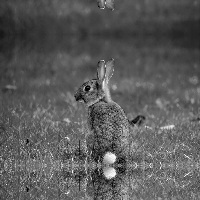

2022-03-15 00:57:32.659 | INFO     | __main__:get_processed_x_y:29 - 8 (200, 200, 3) https://static.wikia.nocookie.net/wildkratts/images/1/12/Eastern_Cottontail_Rabbit_RL.PNG/revision/latest?cb=20191223185526


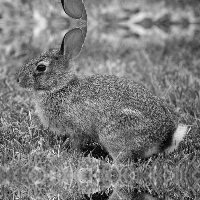

2022-03-15 00:57:32.700 | INFO     | __main__:get_processed_x_y:29 - 9 (200, 200, 3) https://portal.ct.gov/lib/deep/wildlife/images/outreach/fact_sheets/cottontail.jpg


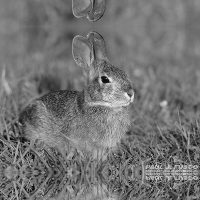

2022-03-15 00:57:32.738 | INFO     | __main__:get_processed_x_y:29 - 10 (200, 200, 3) https://static01.nyt.com/images/2017/12/03/nyregion/03nature/03nature-facebookJumbo.jpg?year=2017&h=335&w=640&s=11620681800fe1a11ec9fba675bb413acb65fd5182c0e7059d63268e9b3812d6&k=ZQJBKqZ0VN


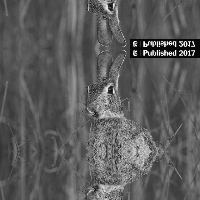

2022-03-15 00:57:32.775 | INFO     | __main__:get_processed_x_y:29 - 11 (200, 200, 3) https://nhpbs.org/wild/images/easterncottontailusfwlewisGorman.jpg


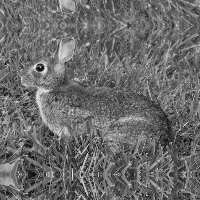

2022-03-15 00:57:32.837 | INFO     | __main__:get_processed_x_y:29 - 12 (200, 200, 3) https://images.squarespace-cdn.com/content/v1/546d61b5e4b049f0b10b95c5/1600191270521-K8R3WLBZ7EK8HXYR07ES/NewEnglandCottontail.jpg


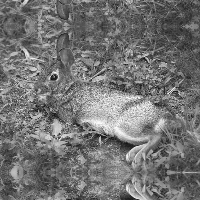

2022-03-15 00:57:32.903 | INFO     | __main__:get_processed_x_y:29 - 13 (200, 200, 3) https://saltspringconservancy.ca/wp-content/uploads/2016/04/Eastern_Cottontail_MinniethePookie.jpg


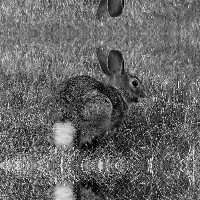

2022-03-15 00:57:33.023 | INFO     | __main__:get_processed_x_y:29 - 14 (200, 200, 3) https://i.natgeofe.com/n/f811d768-b6a0-4655-bd25-83e3d4666b86/eastern-cottontail-rabbit_2x3.jpg


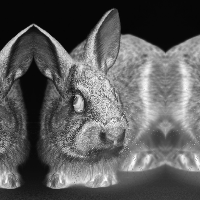

2022-03-15 00:57:33.070 | INFO     | __main__:get_processed_x_y:29 - 15 (200, 200, 3) https://www.venture-rv.com/vacation-planner/4-legged-critters/images/Eastern-Cottontail.jpg


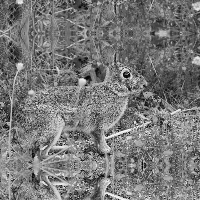

2022-03-15 00:57:33.119 | INFO     | __main__:get_processed_x_y:29 - 16 (200, 200, 3) https://ofnc.ca/wp-content/uploads/2018/02/IMG_7029.jpg


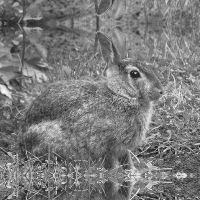

2022-03-15 00:57:33.179 | INFO     | __main__:get_processed_x_y:29 - 17 (200, 200, 3) https://lafeber.com/vet/wp-content/uploads/Cottontail-rabbit-Donald-Hines.jpg


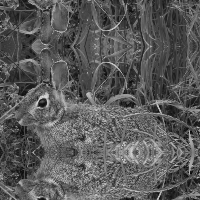

2022-03-15 00:57:33.253 | INFO     | __main__:get_processed_x_y:29 - 18 (200, 200, 3) https://dickinsoncountyconservationboard.com/wp-content/uploads/sites/2/2019/01/Cottontail_Rabbit_4445913041.jpg


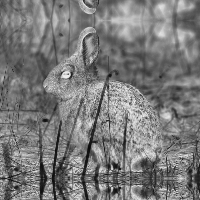

2022-03-15 00:57:33.313 | INFO     | __main__:get_processed_x_y:29 - 19 (200, 200, 3) https://media.istockphoto.com/photos/eastern-cotton-tail-rabbit-tail-jumping-picture-id1192733058?k=20&m=1192733058&s=170667a&w=0&h=m-_5LYh3SHFkUBFPGpy7V3nFMKfm_1a4JWeazc7E_rg=


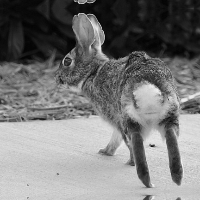

2022-03-15 00:57:33.387 | INFO     | __main__:get_processed_x_y:29 - 20 (200, 200, 3) https://mdc.mo.gov/sites/default/files/styles/species_banner/public/mo_nature/media/images/2011/11/eastern_cottontail_11-15-11.jpg?h=4362216e&itok=tg0fXCth


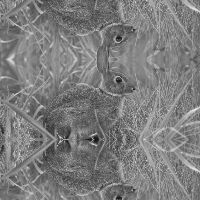

2022-03-15 00:57:33.447 | INFO     | __main__:get_processed_x_y:29 - 21 (200, 200, 3) https://petkeen.com/wp-content/uploads/2021/04/mountain-cottontail-rabbit.jpg


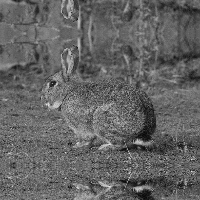

2022-03-15 00:57:33.533 | INFO     | __main__:get_processed_x_y:29 - 22 (200, 200, 3) https://petkeen.com/wp-content/uploads/2021/02/New-England-cottontail-sitting-in-grass_Julie-rubacha_Shutterstock.jpg


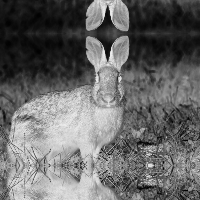

2022-03-15 00:57:33.581 | INFO     | __main__:get_processed_x_y:29 - 23 (200, 200, 3) https://northernnester.com/wp-content/uploads/2019/10/cottontail-rabbits-characteristics.jpg


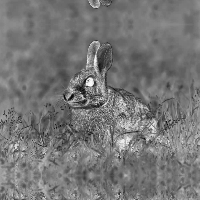

2022-03-15 00:57:33.625 | INFO     | __main__:get_processed_x_y:29 - 24 (200, 200, 3) https://farm66.staticflickr.com/65535/5121053852_86655e5b3d_b.jpg


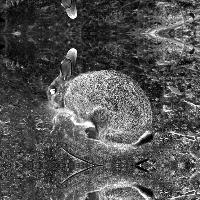

2022-03-15 00:57:33.663 | INFO     | __main__:get_processed_x_y:29 - 25 (200, 200, 3) https://naturegroupie.org/sites/default/files/styles/max_1300x1300/public/images/featurestory_reportthatrabbit.png?itok=ZkhCtXSk


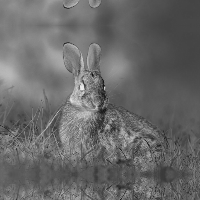

2022-03-15 00:57:33.725 | INFO     | __main__:get_processed_x_y:29 - 26 (200, 200, 3) https://www.naturalhistoryonthenet.com/wp-content/uploads/2016/12/Cottontail-Rabbit.jpg


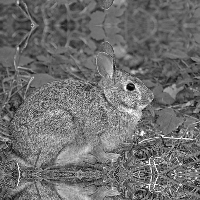

2022-03-15 00:57:33.776 | INFO     | __main__:get_processed_x_y:29 - 27 (200, 200, 3) https://media-cldnry.s-nbcnews.com/image/upload/t_nbcnews-fp-1024-512,f_auto,q_auto:best/streams/2013/August/130807/6C8544572-130807-rabbit-tail-hmed-1050a.jpg


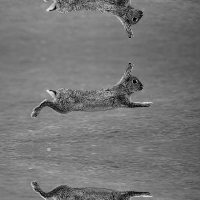

2022-03-15 00:57:33.827 | INFO     | __main__:get_processed_x_y:29 - 28 (200, 200, 3) https://animalstime.com/wp-content/uploads/2016/02/eastern-cottontail-rabbit-2.jpg


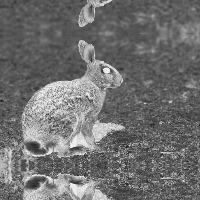

2022-03-15 00:57:33.882 | INFO     | __main__:get_processed_x_y:29 - 29 (200, 200, 3) https://nhpbs.org/wild/images/easterncottontailusfwfrankdoyle.jpg


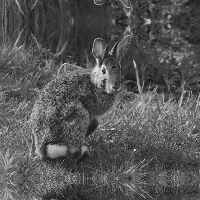

2022-03-15 00:57:33.925 | INFO     | __main__:get_processed_x_y:29 - 30 (200, 200, 3) https://42796r1ctbz645bo223zkcdl-wpengine.netdna-ssl.com/wp-content/uploads/2018/09/7823437366_66f2b7e34d_b.jpg


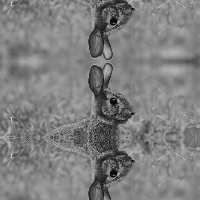

2022-03-15 00:57:33.968 | INFO     | __main__:get_processed_x_y:29 - 31 (200, 200, 3) http://wild-facts.com/wp-content/uploads/2010/04/106442137_2eccfaddcb.jpg


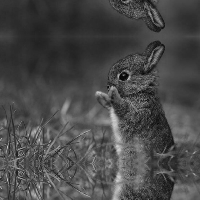

2022-03-15 00:57:34.023 | INFO     | __main__:get_processed_x_y:29 - 32 (200, 200, 3) https://www.gannett-cdn.com/presto/2021/07/16/NNDN/70b13fa8-9fe9-4ea0-addb-f1a203269893-rabbit_tennis.jpg?auto=webp&crop=1999,1125,x0,y101&format=pjpg&width=1200


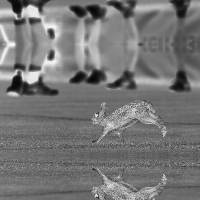

2022-03-15 00:57:34.059 | INFO     | __main__:get_processed_x_y:29 - 33 (200, 200, 3) https://vtfishandwildlife.com/sites/fishandwildlife/files/images/Learn%20More/VT%20Critters/VTFW-Eastern-Cottontail.jpg


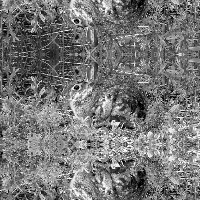

2022-03-15 00:57:34.098 | INFO     | __main__:get_processed_x_y:29 - 34 (200, 200, 3) https://assets.atlasobscura.com/article_images/5159/image


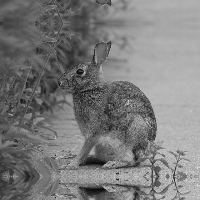

2022-03-15 00:57:34.147 | INFO     | __main__:get_processed_x_y:29 - 35 (200, 200, 3) https://animalia.us-east-1.linodeobjects.com/animals/photos/full/1.25x1/new-england-cottontail-rabbit.jpg


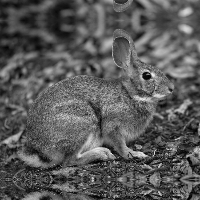

2022-03-15 00:57:34.184 | INFO     | __main__:get_processed_x_y:29 - 36 (200, 200, 3) http://birdoculars.com/wp-content/uploads/2013/02/rabbit-1551117-640x480-1.jpg


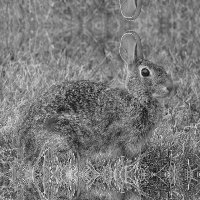

2022-03-15 00:57:34.245 | INFO     | __main__:get_processed_x_y:29 - 37 (200, 200, 3) https://www.northwestwildlife.com/wp-content/uploads/2018/10/nuttals-cottontail-rabbit-700x443.png


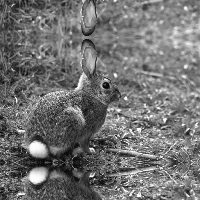

2022-03-15 00:57:34.294 | INFO     | __main__:get_processed_x_y:29 - 38 (200, 200, 3) https://pixfeeds.com/images/24/549757/1200-547226928-eastern-cottontail-sitting-in-flower-garden.jpg


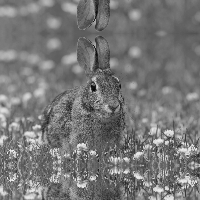

2022-03-15 00:57:34.389 | INFO     | __main__:get_processed_x_y:29 - 39 (200, 200, 3) https://herebunny.com/wp-content/uploads/2020/03/Eastern-Cottontail.jpg


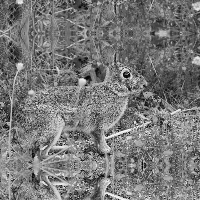

2022-03-15 00:57:34.495 | INFO     | __main__:get_processed_x_y:29 - 40 (200, 200, 3) https://static.wikia.nocookie.net/parody/images/9/9d/Eastern_cottontail.jpg/revision/latest?cb=20141228160546


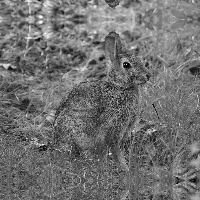

2022-03-15 00:57:34.567 | INFO     | __main__:get_processed_x_y:29 - 41 (200, 200, 3) https://preview.redd.it/2coygp9o81671.jpg?width=640&crop=smart&auto=webp&s=405930472882154a0bbeea5a48e6fecb150b9459


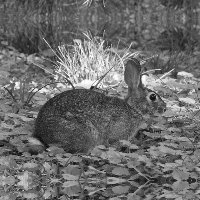

2022-03-15 00:57:34.653 | INFO     | __main__:get_processed_x_y:29 - 42 (200, 200, 3) https://cdn.pixabay.com/photo/2020/10/13/18/48/rabbit-5652587__340.jpg


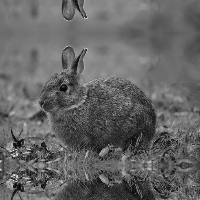

2022-03-15 00:57:34.703 | INFO     | __main__:get_processed_x_y:29 - 43 (200, 200, 3) https://i0.wp.com/thedrewacorn.com/wp-content/uploads/2018/03/thing-link.jpg?fit=640%2C360&ssl=1


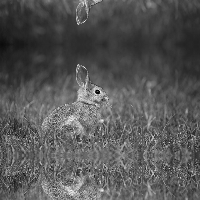

2022-03-15 00:57:34.753 | INFO     | __main__:get_processed_x_y:29 - 44 (200, 200, 3) https://preview.redd.it/cypx9phtut671.jpg?width=640&crop=smart&auto=webp&s=4691f6acd07d58940d87e21a072298cc3e78fecd


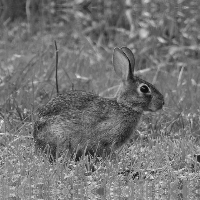

2022-03-15 00:57:34.819 | INFO     | __main__:get_processed_x_y:29 - 45 (200, 200, 3) https://mdc.mo.gov/sites/default/files/styles/card_regular/public/mo_nature/media/images/2010/05/swamp_rabbit.jpg?itok=W5rSaC1v


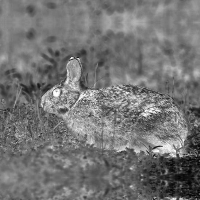

2022-03-15 00:57:34.878 | INFO     | __main__:get_processed_x_y:29 - 46 (200, 200, 3) https://upload.wikimedia.org/wikipedia/commons/4/44/Lepus_europaeus_%28Causse_M%C3%A9jean%2C_Loz%C3%A8re%29-cropped.jpg


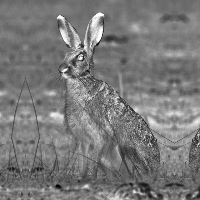

2022-03-15 00:57:34.946 | INFO     | __main__:get_processed_x_y:29 - 47 (200, 200, 3) https://www.worldatlas.com/r/w1200/upload/aa/02/c2/european-hare.jpg


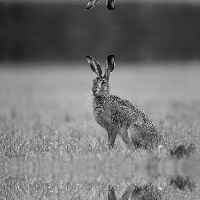

2022-03-15 00:57:35.001 | INFO     | __main__:get_processed_x_y:29 - 48 (200, 200, 3) https://animalia.us-east-1.linodeobjects.com/animals/photos/full/1.25x1/feldhase-im-w4tel.jpg


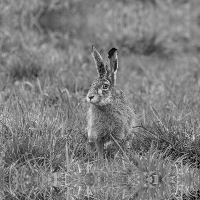

2022-03-15 00:57:35.064 | INFO     | __main__:get_processed_x_y:29 - 49 (200, 200, 3) https://site-539981.mozfiles.com/files/539981/medium/D7500_-_MHare_A1_-_22_9_2020.jpg


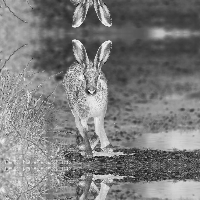

2022-03-15 00:57:35.128 | INFO     | __main__:get_processed_x_y:29 - 50 (200, 200, 3) https://i.pinimg.com/originals/7c/44/d9/7c44d9cb34ce4c760bbf3af32c02d433.jpg


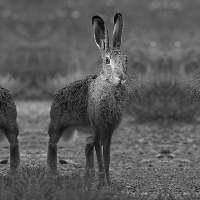

2022-03-15 00:57:35.188 | INFO     | __main__:get_processed_x_y:29 - 51 (200, 200, 3) https://www.animalfunfacts.net/images/stories/photos/mammals/leporidae/european_hare/european_hare_l.jpg


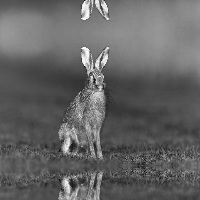

2022-03-15 00:57:35.277 | INFO     | __main__:get_processed_x_y:29 - 52 (200, 200, 3) https://upload.wikimedia.org/wikipedia/commons/8/8c/European_Hare_2012-07-30_1.JPG


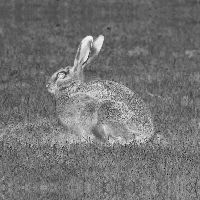

2022-03-15 00:57:35.314 | INFO     | __main__:get_processed_x_y:29 - 53 (200, 200, 3) http://www.wild-facts.com/wp-content/uploads/2011/06/696px-Feldhase_Schiermonnikoog.jpg


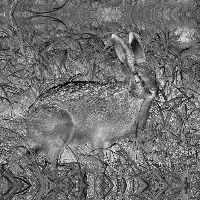

2022-03-15 00:57:35.373 | INFO     | __main__:get_processed_x_y:29 - 54 (200, 200, 3) https://www.animalfunfacts.net/images/stories/photos/mammals/leporidae/european_hare/european_hare_facts_l.jpg


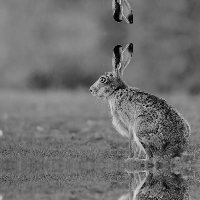

2022-03-15 00:57:35.438 | INFO     | __main__:get_processed_x_y:29 - 55 (200, 200, 3) https://animalcorner.org/wp-content/uploads/2015/02/european-hare-1.jpg


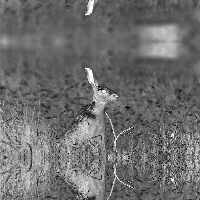

2022-03-15 00:57:35.539 | INFO     | __main__:get_processed_x_y:29 - 56 (200, 200, 3) https://live.staticflickr.com/4749/40287411952_4c668fee0c_b.jpg


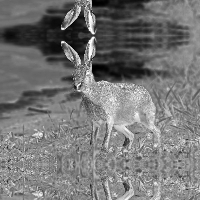

2022-03-15 00:57:35.621 | INFO     | __main__:get_processed_x_y:29 - 57 (200, 200, 3) https://cdn.britannica.com/46/1146-050-AF131F7D/jackrabbits-North-America-plains.jpg


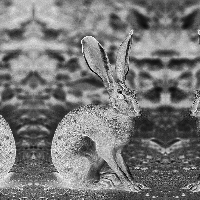

2022-03-15 00:57:35.798 | INFO     | __main__:get_processed_x_y:29 - 58 (200, 200, 3) https://www.wildlifeonline.me.uk/assets/ugc/images/brown_hare_tboosey.jpg


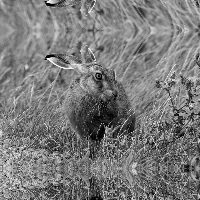

2022-03-15 00:57:35.965 | INFO     | __main__:get_processed_x_y:29 - 59 (200, 200, 3) https://www.worldatlas.com/r/w1200/upload/72/74/62/shutterstock-1023603496.jpg


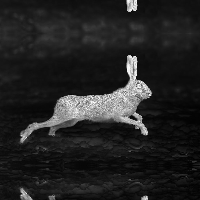

2022-03-15 00:57:36.020 | INFO     | __main__:get_processed_x_y:29 - 60 (200, 200, 3) https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/amazing-wild-european-hare-close-up-sat-in-a-arable-field-simon-bratt-photography-lrps.jpg


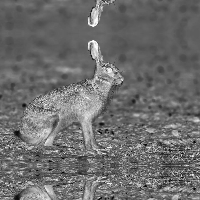

2022-03-15 00:57:36.084 | INFO     | __main__:get_processed_x_y:29 - 61 (200, 200, 3) https://agriculture.vic.gov.au/__data/assets/image/0017/660014/Hare.jpg


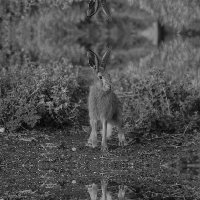

2022-03-15 00:57:36.183 | INFO     | __main__:get_processed_x_y:29 - 62 (200, 200, 3) http://invasivespeciesireland.com/wp-content/uploads/2020/05/Silviu-Petrovan.png


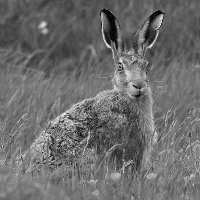

2022-03-15 00:57:36.259 | INFO     | __main__:get_processed_x_y:29 - 63 (200, 200, 3) https://observation.org/media/photo/1051897.jpg


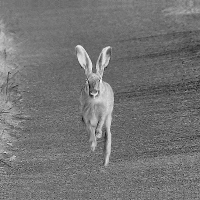

2022-03-15 00:57:36.347 | INFO     | __main__:get_processed_x_y:29 - 64 (200, 200, 3) https://bybio.files.wordpress.com/2018/03/963106a1-729c-4317-8818-1d5fedb08d36.jpeg


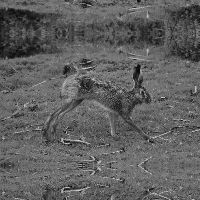

2022-03-15 00:57:36.413 | INFO     | __main__:get_processed_x_y:29 - 65 (200, 200, 3) https://i.pinimg.com/originals/44/cc/a5/44cca57e0f9922e9a49b2f13096ba299.jpg


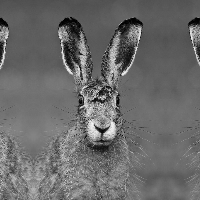

2022-03-15 00:57:36.467 | INFO     | __main__:get_processed_x_y:29 - 66 (200, 200, 3) https://alpinestock.com/samples/Mjk3NTQyOWVkNWZlYTY0/ODMzMjllZDVmZWE2NA==/sitting-european-hare-(Lepus-europaeus).jpg


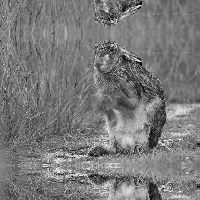

2022-03-15 00:57:36.533 | INFO     | __main__:get_processed_x_y:29 - 67 (200, 200, 3) https://observation.org/media/photo/26747285.jpg


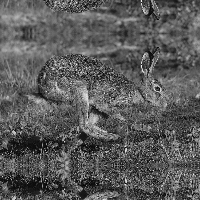

2022-03-15 00:57:36.611 | INFO     | __main__:get_processed_x_y:29 - 68 (200, 200, 3) https://ptes.org/wp-content/uploads/2014/06/brownhare2-credit-Robin-Hamilton-e1403787479433.jpg


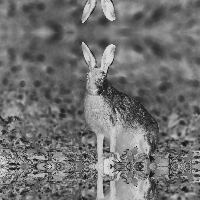

2022-03-15 00:57:36.696 | INFO     | __main__:get_processed_x_y:29 - 69 (200, 200, 3) https://live.staticflickr.com/3194/2929177200_1d0a4832ba_c.jpg


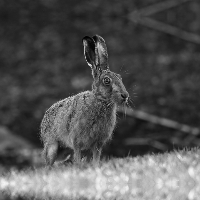

2022-03-15 00:57:36.793 | INFO     | __main__:get_processed_x_y:29 - 70 (200, 200, 3) https://natureguelphtracking.files.wordpress.com/2014/06/june-2014-072.jpg


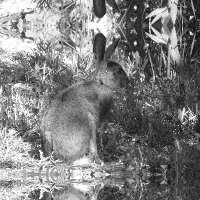

2022-03-15 00:57:36.854 | INFO     | __main__:get_processed_x_y:29 - 71 (200, 200, 3) https://animalia.us-east-1.linodeobjects.com/animals/photos/small/1x1/halljnes.jpg


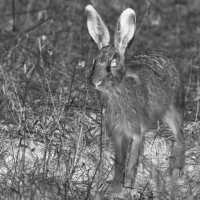

2022-03-15 00:57:36.956 | INFO     | __main__:get_processed_x_y:29 - 72 (200, 200, 3) https://pm1.narvii.com/6785/0c276e429d4087cee7aedfc7be1e532ee1908455v2_hq.jpg


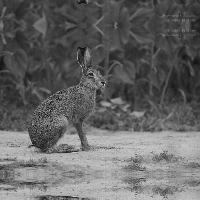

2022-03-15 00:57:37.018 | INFO     | __main__:get_processed_x_y:29 - 73 (200, 200, 3) https://www.waldwissen.net/assets/_processed_/4/2/csm_lwf_hasenhochzeit_teaser_373179a8e0.jpg


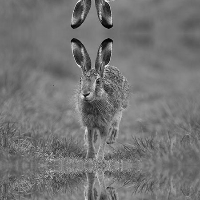

2022-03-15 00:57:37.120 | INFO     | __main__:get_processed_x_y:29 - 74 (200, 200, 3) https://i.pinimg.com/originals/78/92/c3/7892c3ab900090a2984e7f81b274714e.jpg


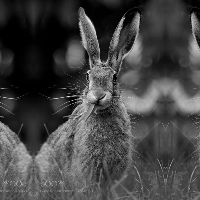

2022-03-15 00:57:37.201 | INFO     | __main__:get_processed_x_y:29 - 75 (200, 200, 3) https://animalia.us-east-1.linodeobjects.com/animals/photos/small/1x1/zayats-rusak-lepus-europaeus-brown-hare-div-zaek-feldhase.jpg


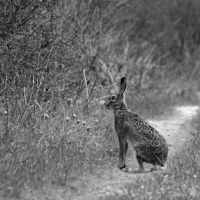

2022-03-15 00:57:37.320 | INFO     | __main__:get_processed_x_y:29 - 76 (200, 200, 3) https://upload.wikimedia.org/wikipedia/commons/f/f1/European_hare.jpg


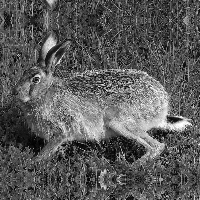

2022-03-15 00:57:37.419 | INFO     | __main__:get_processed_x_y:29 - 77 (200, 200, 3) https://envato-shoebox-0.imgix.net/7147/7a57-7ba6-4fb4-af74-d09f7bf2323e/European+Hare+sitting+in+field+MB_L8431.jpg?auto=compress%2Cformat&fit=max&mark=https%3A%2F%2Felements-assets.envato.com%2Fstatic%2Fwatermark2.png&markalign=center%2Cmiddle&markalpha=18&w=700&s=c264ea7f0e3429f2f551f9685c5ede17


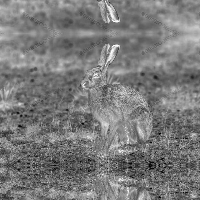

2022-03-15 00:57:37.497 | INFO     | __main__:get_processed_x_y:29 - 78 (200, 200, 3) https://inaturalist-open-data.s3.amazonaws.com/photos/10326/large.jpg


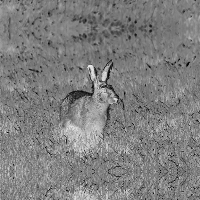

2022-03-15 00:57:37.595 | INFO     | __main__:get_processed_x_y:29 - 79 (200, 200, 3) https://di14q5sgut590.cloudfront.net/generated/a41f03e6-6790-45a2-98d8-98759567569f-270x240.jpg


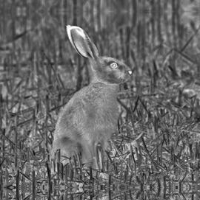

2022-03-15 00:57:37.661 | INFO     | __main__:get_processed_x_y:29 - 80 (200, 200, 3) https://videohive.img.customer.envatousercontent.com/files/af9b79ab-4d89-4ded-bad8-cf868bb5fea0/inline_image_preview.jpg?auto=compress%2Cformat&fit=crop&crop=top&max-h=8000&max-w=590&s=e9034093175da2a63ab7221276dfb26b


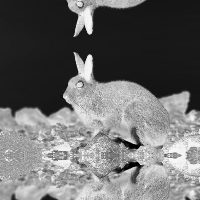

2022-03-15 00:57:37.726 | INFO     | __main__:get_processed_x_y:29 - 81 (200, 200, 3) https://i.ytimg.com/vi/8hEKqUG-WVc/maxresdefault.jpg


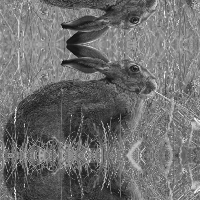

2022-03-15 00:57:37.788 | INFO     | __main__:get_processed_x_y:29 - 82 (200, 200, 3) https://www.furfeatherandfin.com/media/wysiwyg/Blogs/hare1.jpg


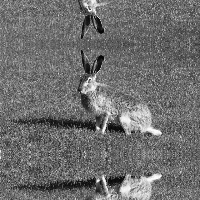

2022-03-15 00:57:37.841 | INFO     | __main__:get_processed_x_y:29 - 83 (200, 200, 3) https://www.wildlifetrusts.org/sites/default/files/styles/node_hero_default/public/2017-12/DTi04_11042011_0472.jpg?h=88239a14&itok=noAhIpWV


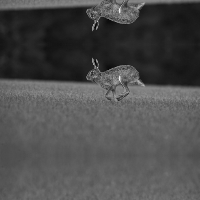

2022-03-15 00:57:37.899 | INFO     | __main__:get_processed_x_y:29 - 84 (200, 200, 3) https://www.westend61.de/images/0001240663pw/european-hare-lepus-europaeus-leveret-elmley-marshes-national-nature-reserve-north-kent-marshes-isle-of-sheppey-kent-england-united-kingdom-europe-RHPLF04706.jpg


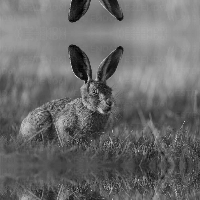

In [91]:
from albumentations.augmentations.transforms import LongestMaxSize
from sklearn.preprocessing import OneHotEncoder
import albumentations as A


def get_x_y_preprocessors(y: RawY):
  logger.info(y.shape)
  
  encoder = OneHotEncoder(sparse=False).fit(y)
  transform = A.Compose([A.ToGray(p=1.0), LongestMaxSize(200),
                         A.PadIfNeeded(min_height=200, min_width=200)])

  return transform, encoder

data = get_data()
x,y = get_x_y(data)

def get_processed_x_y(X: RawX, Y: RawY):

  x_encoder,y_encoder = get_x_y_preprocessors(Y)

  min_width = float('inf')
  x_t = []
  for i, x_sample in enumerate(x):
    x_data = {"image": x_sample}
    encoded_object = x_encoder(**x_data)
    transformed_image = encoded_object["image"]
    _, width, _ = transformed_image.shape
    logger.info(f"{i} {transformed_image.shape} {data.iloc[i, 1]}")
    cv2_imshow(transformed_image)
    min_width = min(width, min_width)
    x_t.append(transformed_image)

  encoder = OneHotEncoder(sparse=False)
  y_transformed: np.ndarray = encoder.fit_transform(y)

  return x_t, y_transformed
x_t, y_t = get_processed_x_y(x,y)

# Data Processing

In [92]:
import tensorflow as tf


# Experiment #1: Basic Model architecture with overfitting

In [93]:
from tensorflow.keras import layers, models

In [94]:
x_t

[array([[[154, 154, 154],
         [154, 154, 154],
         [149, 149, 149],
         ...,
         [ 78,  78,  78],
         [ 82,  82,  82],
         [ 83,  83,  83]],
 
        [[156, 156, 156],
         [155, 155, 155],
         [152, 152, 152],
         ...,
         [ 75,  75,  75],
         [ 79,  79,  79],
         [ 82,  82,  82]],
 
        [[156, 156, 156],
         [155, 155, 155],
         [152, 152, 152],
         ...,
         [ 77,  77,  77],
         [ 76,  76,  76],
         [ 78,  78,  78]],
 
        ...,
 
        [[167, 167, 167],
         [175, 175, 175],
         [162, 162, 162],
         ...,
         [120, 120, 120],
         [132, 132, 132],
         [124, 124, 124]],
 
        [[144, 144, 144],
         [115, 115, 115],
         [121, 121, 121],
         ...,
         [124, 124, 124],
         [131, 131, 131],
         [167, 167, 167]],
 
        [[140, 140, 140],
         [103, 103, 103],
         [107, 107, 107],
         ...,
         [131, 131, 131],
  

In [95]:
y_t

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [96]:
shapes = []
for i in range(len(x)):

 shapes.append(x_t[i].shape)

print(max(shapes))
print(shapes)

(200, 200, 3)
[(200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200,

In [164]:
# Sample Model

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(200,200,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation = "sigmoid"))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 313632)            0         
                                                                 
 dense_9 (Dense)             (None, 2)                 627266    
                                                                 
Total params: 628,162
Trainable params: 628,162
Non-trainable params: 0
_________________________________________________________________


In [120]:
x_t[0].shape

(200, 200, 3)

In [122]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.asarray(x_t), np.asarray(y_t), test_size = 0.2, random_state = 42)

In [127]:
y_train[0].shape

(2,)

In [165]:
np.random.seed(42)

In [166]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [167]:
model.fit(x_train,y_train,epochs = 10,batch_size=32, validation_data=(x_test,y_test))

Epoch 1/10
3/3 [==============================] - 2s 492ms/step - loss: 2535.7402 - accuracy: 0.5441 - val_loss: 3447.7527 - val_accuracy: 0.5294
Epoch 2/10
3/3 [==============================] - 1s 412ms/step - loss: 1606.9976 - accuracy: 0.5441 - val_loss: 3891.6934 - val_accuracy: 0.4706
Epoch 3/10
3/3 [==============================] - 1s 412ms/step - loss: 3842.3025 - accuracy: 0.4559 - val_loss: 1618.9738 - val_accuracy: 0.4706
Epoch 4/10
3/3 [==============================] - 1s 415ms/step - loss: 831.6757 - accuracy: 0.5294 - val_loss: 1759.8037 - val_accuracy: 0.5294
Epoch 5/10
3/3 [==============================] - 1s 407ms/step - loss: 1716.6469 - accuracy: 0.5441 - val_loss: 1888.4928 - val_accuracy: 0.5294
Epoch 6/10
3/3 [==============================] - 1s 406ms/step - loss: 1329.8740 - accuracy: 0.5441 - val_loss: 407.8375 - val_accuracy: 0.5294
Epoch 7/10
3/3 [==============================] - 1s 419ms/step - loss: 177.6906 - accuracy: 0.6471 - val_loss: 722.9841 - val

**Overfit a single batch:**

In [170]:

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(200,200,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation = "sigmoid"))
model.summary()
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=1,epochs = 100,validation_data=(x_test,y_test))

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 313632)            0         
                                                                 
 dense_12 (Dense)            (None, 2)                 627266    
                                                                 
Total params: 628,162
Trainable params: 628,162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
68/68 [==============================] - 4s 47ms/step - loss: 1010.6678 - accuracy: 0.5000 - val_loss